## Import Python Libraries

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import pickle

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from PIL import Image
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [46]:
data_dir = f"../data/formatted_800x600.pickle"
df = pd.read_pickle(data_dir)

In [47]:
df["image"][0]

array([[[170, 154, 133],
        [165, 149, 127],
        [159, 143, 120],
        ...,
        [ 19,  17,  18],
        [ 18,  16,  17],
        [ 13,  11,  12]],

       [[166, 152, 129],
        [158, 145, 121],
        [149, 133, 109],
        ...,
        [ 19,  17,  18],
        [ 18,  16,  17],
        [ 13,  11,  12]],

       [[158, 146, 120],
        [153, 140, 115],
        [145, 131, 107],
        ...,
        [ 19,  17,  18],
        [ 18,  16,  17],
        [ 13,  11,  12]],

       ...,

       [[178, 163, 132],
        [171, 156, 126],
        [166, 153, 123],
        ...,
        [181, 175, 140],
        [180, 176, 141],
        [180, 177, 144]],

       [[198, 184, 152],
        [192, 179, 147],
        [189, 177, 146],
        ...,
        [184, 178, 144],
        [183, 180, 146],
        [181, 179, 145]],

       [[210, 196, 160],
        [205, 191, 156],
        [200, 189, 154],
        ...,
        [183, 178, 144],
        [183, 177, 143],
        [176, 172, 137]]

In [ ]:
with open(data_dir, "wb") as file:
    pickle.dump(df,file)

In [ ]:
df_1 = pd.read_pickle("/content/drive/MyDrive/APS360/Data/size800x600.pickle")

In [ ]:
try: df = df.drop(columns=["polarity"])
except: pass
df.columns

Index(['image', 'targets'], dtype='object')

In [6]:
def show_image(image): 
    plt.imshow(image)

def show_sample(sample): 
    (image, targets) = sample
    fig, axes = plt.subplots(1)
    axes.imshow(image)
    for box, label in zip(targets["boxes"], targets["labels"]):
        color = "red" if label == 0 else "green"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        axes.add_patch(bounding_box)

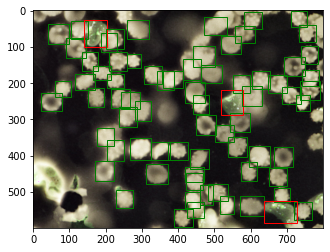

In [48]:
show_sample(df.iloc[0].values)

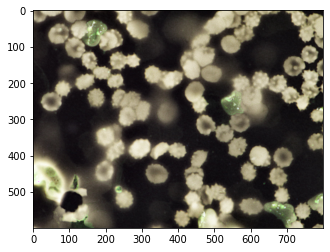

In [41]:
image = df["image"][0]
label = df["targets"][0]
plt.imshow(image)

Elapsed time: 0.00700068473815918


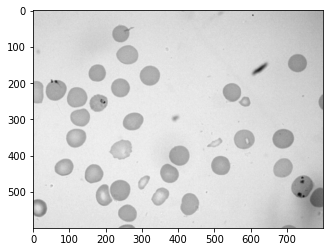

In [27]:
start = time.time()
gray_image = rgb2gray(image)
print(f"Elapsed time: {time.time() - start}")
plt.imshow(gray_image, cmap=mpl.cm.gray)

Elapsed time: 0.3051149845123291


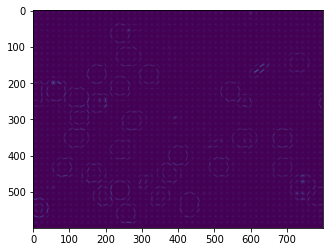

In [36]:
# Histogram of oriented gradients
start_time = time.time()
hog_features, hog_image = hog(gray_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
print(f"Elapsed time: {time.time() - start_time}")

plt.imshow(hog_image)#, cmap=mpl.cm.gray)
plt.show()

In [10]:
def create_features(images):
    hog_features = np.zeros((len(images), 136080))
    for i, image in enumerate(images): 
        gray_image = rgb2gray(image.numpy().transpose(1, 2, 0))
        hog_features[i] = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    return torch.tensor(hog_features)

def get_features(loader): 
    features = []
    for images, labels in loader: 
        features.append(create_features(images))
    return features

In [11]:
# positive (0) if the sample contains infected cells
# negative (1) if the sample does not
def get_polarity(targets):
    for label in targets["labels"]: 
        if label.item() == 0: 
            return 0
    return 1

In [12]:
count = 0
polarities = []
for i, (image, targets) in df.iterrows(): 
    polarity = get_polarity(targets)
    if polarity == 1:
        count+=1
    polarities.append(get_polarity(targets))
df["polarity"] = polarities
print(count)

192


In [13]:
class PolarityDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image, targets, polarity = self.dataframe[index]
        if self.transform: 
            image = self.transform(image)
        return image, polarity

def get_loader(df, batch_size):
    dataset = PolarityDataset(df, transform = transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader

In [14]:
np.random.seed(1000)
np_df = df.to_numpy()
np.random.shuffle(np_df)

df_trn = np_df[:int(len(np_df) * 0.8)]
df_val = np_df[int(len(np_df) * 0.8):int(len(np_df) * 0.9)]
df_tst = np_df[int(len(np_df) * 0.9):]

batch_size = 32

In [ ]:
print(df_trn.shape)

(1062, 3)


In [ ]:
print(df_trn[0])

In [ ]:
dataset, loader = get_loader(np_df, batch_size)

In [15]:
trn_dataset, trn_loader = get_loader(df_trn, batch_size)
val_dataset, val_loader = get_loader(df_val, batch_size)
tst_dataset, tst_loader = get_loader(df_tst, batch_size)

In [17]:
trn_features = get_features(trn_loader)
val_features = get_features(val_loader)
tst_features = get_features(tst_loader)

## HOG: Histogram of Oriented gradients

SVM Model

In [22]:
class WindowDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image, targets, polarity = self.dataframe[index]
        if self.transform: 
            image = self.transform(image)
        return image, targets

def get_window_loader(df, batch_size):
    dataset = WindowDataset(df, transform = transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader

In [23]:
window_df_trn = np.array([sample for sample in df_trn if sample[2] == 1])
_, window_loader = get_window_loader(window_df_trn,1)

In [38]:
def get_HOG_features(image):
    gray_image = rgb2gray(image.cpu().numpy().transpose(1, 2, 0))
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    return torch.tensor(hog_features)

In [ ]:
def check(target, window):
    x, y, size = window
    if target[0] >= x and target[2] <= x+size:
        if target[1] >= y and target[3] <= y+size:
            return True
    return False

In [40]:
false_positive_features = []
window_size = 80
window_label = 1 # never infected
for image,targets in window_loader:
    image = image.squeeze()
    image = image.to(device)
    # targets["boxes"] = targets["boxes"].squeeze().to(device)
    # targets["labels"] = targets["labels"].squeeze().to(device)
    for i in range(image.shape[-1]-window_size):
        for j in range(image.shape[-2]-window_size):
            window_image = transforms.functional.crop(image,j,i,window_size,window_size)
            hog_feature = get_HOG_features(window_image)
            hog_feature = hog_feature.float().to(device)
            output = model(hog_feature)
            if output <= 0.5:
                false_positive_features.append((output,hog_feature))
            loss = criterion(output, window_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Window Start : ({i}, {j}), Loss: {loss.item()}, false_positive_features length: {len(false_positive_features)}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x729 and 136080x1024)

### Training on Negative Samples

In [ ]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=len(dataset))
# use fit_transform to run PCA on our standardized matrix
pca_1 = ss.fit_transform(stand)
# look at new shape
print('PCA matrix shape is: ', pca_1.shape)

Feature matrix shape is:  (1328, 136080)
PCA matrix shape is:  (1328, 136080)


In [ ]:
X = pd.DataFrame(pca_1)
y = pd.Series(df.label.values)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

## Model Training

In [ ]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

X_train = 
# fit model
svm.fit(X_train, y_train)

## Model Evaluation

In [ ]:
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)